In [2]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18


#GLOBAL VARIABLES

#ctes
mn=0.9315 # nucleon mass in GeV/c2
NA=6.022e23 # Avogadro's number
c=3e8 # speed of light in m/s
hbar = 6.582e-16 # eV*s
sqrtpi=m.sqrt(m.pi)

#DM halo
rho=0.3 # dark matter local density Gev/c2/cm3
vesc=544 # escape velocity in km/s

# Sun velocity
u1=np.array([ 0.9941, 0.1088, 0.0042])
u2=np.array([-0.0504, 0.4946, -0.8677])
v0=np.array([0, 238, 0]) # local standard of rest, km/s
v0M=m.sqrt(v0.dot(v0))
vpec=np.array([11.1, 12.2, 7.3]) # sun peculiar velocity
vsun=v0+vpec # SUN VELOCITY
omega=0.0172 # angular frequency, in d-1 (2pi/365)
vorb=29.8 # Earth's orbital velocity in km/s
timeMax=72.9 # day of maximum earth's velocity: 2nd June, starting from 22 March
timeMin=255.5 # day of minimum earth velocity, starting from 22 March
timeAvg=(timeMax+timeMin)/2.
ene=np.arange(0,100,1)
time=np.arange(0,365,1)

#################
# EARTH VELOCITY, in km/s
#################
def vearth(t):
  v = vsun + vorb*(m.cos(omega*t)*u1+m.sin(omega*t)*u2)
  return m.sqrt(v.dot(v))
  #return np.linalg.norm(v)

#################
# minimum DM velocity to be detected with threshold E (in km/s)
# E in keV_NR
# A: mass number
# mW: wimp mass in GeV/c^2
def vmin(E,A,mW):
  mN=A*mn
  mu_N=mW*mN/(mW+mN)
  return m.sqrt(E*mN*1e-6/2./mu_N/mu_N)*c*1e-3 # km/s
#################
# mean inverse speed function (in s/km)
# E in keV_NR
# t: time in days since 22 March
# A: mass number
# mW: wimp mass in GeV/c^2
def eta(E,t,A,mW):
  x=vmin(E,A,mW)/v0M
  y=vearth(t)/v0M
  z=vesc/v0M
  N=m.erf(z)-2*z/sqrtpi*m.exp(-z*z)
  retval=1./2/y/v0M/N
  if x > z+y:
    return 0
  if x > z-y:
    retval*=m.erf(z)-m.erf(x-y)-2/sqrtpi*(z+y-x)*m.exp(-z*z)
  else:
    retval*=m.erf(x+y)-m.erf(x-y)-4/sqrtpi*y*m.exp(-z*z)
  return retval

#################
# Form factor
# E in keV_NR
# A: mass number
def FF(E,A):
  if E==0:
    return 1
  R=1.2*A**0.3333 # fm
  s=1 # fm
  mN=A*mn
  R1=m.sqrt(R*R-5*s*s) # fm
  R1*=1e-6/hbar/c

  q=m.sqrt(2*1e-6*mN*E) # GeV
  x=q*R1
  #print("mN = " + str(mN) + " E= "+str(E)+ " q="+str(q)+" R1="+str(R1)+" x= " + str(x) + "hbarc= " +str(hbar*c*1e6))
  retval=m.sin(x)/x/x-m.cos(x)/x
  retval*=3/x
  retval*=retval
  aux=q*s*1e-6/hbar/c
  retval*=m.exp(-aux*aux)
  return retval


#########################
#########################
# differential rate in the detector (in c/kevee/kg/y) for a generic nucleus (A) 
# E: in keVee
# t: time in days since March 22
# mW: Wimp mass in GeV/c^2
# sigmaSI: SI cross section in cm^2
# Q is the quenching factor at energy Eee(keVee) for nucleus A
def rate_ee(Eee,t,A,mW,sigmaSI, Q=1):
  # convert Eee to keV_NR
  E =Eee/Q
  mN=A*mn
  Mdet=NA*mN*1000 # GeV/c2/kg
  mu_n=mW*mn/(mW+mn)
  retval=Mdet*rho/2./mW*A/mu_n/mu_n*sigmaSI*c*c
  retval*=8.64e-3 # to convert to counts/kg/keV/d
  retval*=365 # convert to counts/kg/keV/y
  retval*=FF(E,A)
  retval*=eta(E,t,A,mW)
  #return reate per keVee
  retval/=Q
  return retval

#########################
#########################
# differential rate in NaI detector (in c/kevee/kg/y) 
# E: in keVee
# t: time in days since March 22
# mW: Wimp mass in GeV/c^2
# sigmaSI: SI cross section in cm^2
# QNa is the quenching factor at energy Eee(keVee) for Na
# QI is the quenching factor at energy Eee(keVee) for I
def rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
  # convert Eee to keV_NR
  rateNa = rate_ee(Eee,t,23,mW,sigmaSI,QNa)
  rateI = rate_ee(Eee,t,127,mW,sigmaSI,QI)
 
  return (rateNa*23.+rateI*127.)/(23.+127.)

#   Return the NaI quenching factor evaluated at electron-equivalent energy ee
#   Parameters
# ee : float or array-like Electron-equivalent energy.
# Returnsfloat or np.ndarray
# Quenching factor QF(ee), linearly interpolated on the (x=ER*QF, y=QF) graph
# constructed for ER in [1, 100] with N=200 points.
# From modified Lindhard Fit of Na QF data (Tamara's thesis)
# k = 0.072, alpha = 0.007
# epsilon = alpha * ER
# g(ER)=3*pow(epsilon, 0.15) + 0.7*pow(epsilon,0.6) + epsilon
# QF(ER)=k*g(ER)/(1+k*g(ER))
# Eee=ER*QF(ER)

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)

    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf

    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)

    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)

    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf

    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

#########################
#########################
# total rate, integrated between Eiee and Efee (in c/kg/y)
# Eiee, Efee: Initial and final energies in keVee
# t: time in days since March 22
# A: mass number
# mW: Wimp mass in GeV/c^2
# sigmaSI: SI cross section in cm^2
def totalRate_NaI(Eiee,Efee,t,mW,sigmaSI):
  energy_ee = np.arange(Eiee,Efee,0.1)
  qfNa = getQFNa(energy_ee)
  qfI = getQFI(energy_ee)
  rates = np.array([
        rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)
    ])

  return rates.sum()*0.1


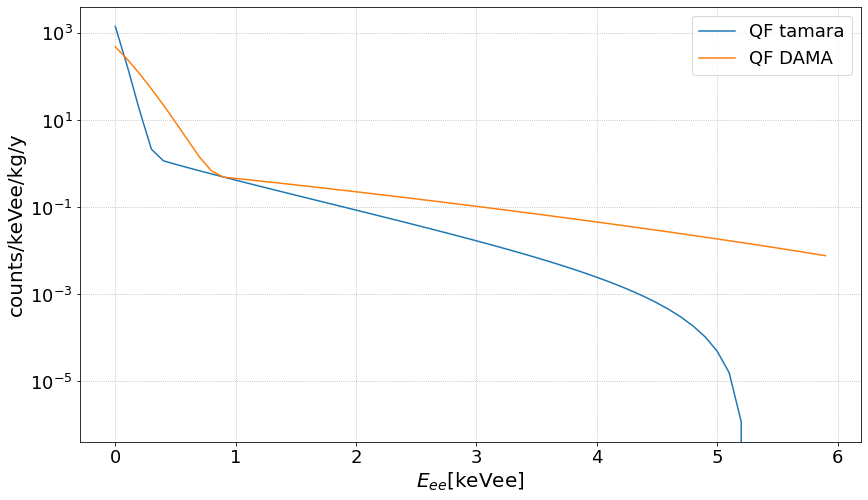

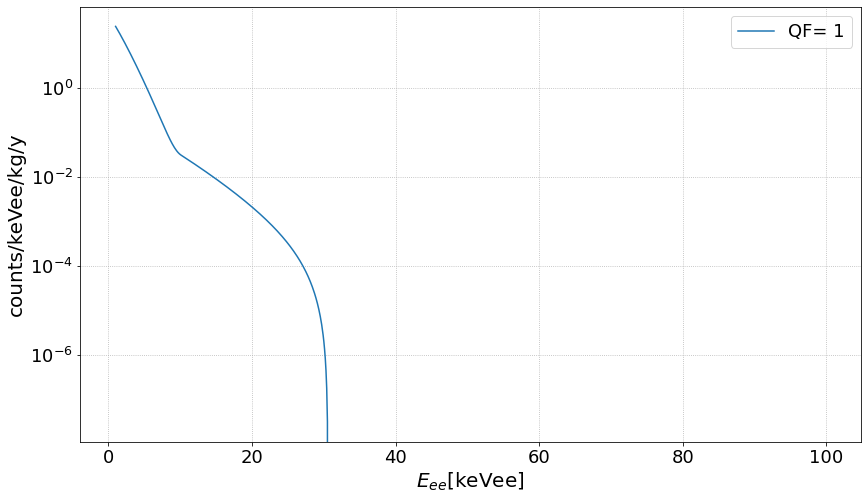

In [3]:
mW=10
sigmaSI=1e-40
energy_ee = np.arange(0, 6, 0.1)
qfNa = getQFNa(energy_ee)
qfI = getQFI(energy_ee)
scale=1./365 # pass to counts /keVee/kg/d
#scale=1 # in counts/keVee/kg/y
ratesNaI = np.array([
        scale*rateNaI_ee(e, timeAvg, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)
    ])
ratesNaI_DAMA = np.array([
        scale*rateNaI_ee(e, timeAvg, mW, sigmaSI, 0.3, 0.09)
        for e  in energy_ee
    ])

plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(energy_ee,ratesNaI,label="QF tamara")
ax.plot(energy_ee,ratesNaI_DAMA,label="QF DAMA")
ax.set_yscale('log')
ax.set_ylabel('counts/keVee/kg/y',fontsize=20)
ax.set_xlabel('$E_{ee}$'+ '[keVee]',fontsize=20)
ax.grid(True, which='both', linestyle=':', linewidth=0.8)
ax.legend()

energy_NR = np.arange(1, 100, 0.1)
ratesNaIQF1 = np.array([
        scale*rateNaI_ee(e, timeAvg, mW, sigmaSI,1,1) # QF=1
        for e in energy_NR
    ])
plt.figure(figsize=(14, 8))
ax = plt.subplot()
ax.plot(energy_NR,ratesNaIQF1,label="QF= 1")
ax.set_yscale('log')
ax.set_ylabel('counts/keVee/kg/y',fontsize=20)
ax.set_xlabel('$E_{ee}$'+ '[keVee]',fontsize=20)
ax.grid(True, which='both', linestyle=':', linewidth=0.8)
ax.legend()

In [4]:
rateNaI_ee(1,timeAvg,mW,sigmaSI,1,1)



8673.035548059835

In [5]:
energy_ee = np.arange(1, 6, 0.1)
qfNa = getQFNa(energy_ee)
qfI = getQFI(energy_ee)
getQFI(20)


0.07799999999999999